# Project 4 : Clustering analysis on Open Research Dataset CORD 19

## Overview
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups
have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over
57,000 scholarly articles, including over 45,000 with full text, about COVID-19, SARS-CoV-2, and
related coronaviruses. This freely available dataset is provided to the global research community. As
a big data community, how can we help researchers to easily find the related research papers
easily?

You can find the dataset and the main challenge on kaggle

https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

## Goals
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health
professionals to keep up with new information on the virus. Can clustering similar research articles
together simplify the search for related publications? How can the content of the clusters be
qualified? And over each cluster how can we recommend the most similar papers leveraging
clustering?

## Requirements
you are required to find out the best way to cluster the research papers using the research
papers details in the JSON file with the metadata in the CSV file, then you should build a
neighborhood recommender system to receive the title of research paper and recommend
the most N similar papers to it based on its cluster. So you should find a way to represent
the papers in vectors and cluster them then build a neighbourhood recommender system
on the clusters.

### Required Steps

#### 1. Read the dataset using spark:
The dataset is 8GB so we don’t expect you can manage the whole entire dataset on your local machine.

#### 2. Do exploratory data analysis:
Do the EDA to understand your data and extract insights help you in feature
engineering ,Document your insights

#### 3. Preparation and Cleaning the data:
- Joining the json file with the metadata in the csv file
- Handling Nulls.
- Handling Duplications.
- Keep Only the english documents

#### 4. Preprocessing:
Our main goal is to clean and preprocess the txt to prepare it to represent it in
vectors. It is a mandatory step in NLP projects to preprocess the text. You can have
a look in this article to explore some of well known preprocessing steps

https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79

##### Required preprocessing
1. Remove stop words.

2. Remove custom stop words, Research papers will often frequently use words that don't actually contribute to the meaning and are not considered everyday stopwords and should be removed to enhance the accuracy.
        custom_stop_words = [ 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', Elsevier', 'PMC', 'CZI', 'www']


3. Remove Punctuation, use this Regex

        '!()-[]{};:'"\,<>./?@#$%^&*_~'


4. convert text to lower case.


#### 5. Vectorization:
convert the data into a format that can be handled by our algorithms. For this purpose we can use *Word2vec*.

#### 6. Clustering
Apply clustering algorithm on the data. You can use *PCA* to reduce the dimensions while still keeping *95\%* variance for better performance and hopefully remove some noise/outliers.

#### 7. Clustering Evaluation
Use ClusteringEvaluator to evaluate the clusters using silhouette and choose the best k you decide from the *elbow* method.

#### 8. Recommender system
Build a very basic recommender system:
- Create a function with the signature *recommendPaper(paper_title,N)* where N is the number of recommended papers in the list and it returns the recommendation list.
- Recommend top N recommendation list based on the most similar(*cosine similarity*) papers to it with respect to the cluster it belongs.

## Install required packages:

In [1]:
# !sudo pip3 install langdetect

## Import required packages:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from langdetect import detect
import numpy as np
import pandas as pd 
import pylab as pl

## Create Spark session

In [2]:
spark = SparkSession \
    .builder \
    .appName('CORD-19 Clustering') \
    .getOrCreate()

## 1. Read the dataset using spark
### Read metadata

In [5]:
metadata = spark.read\
                .format('csv')\
                .option('header', 'true')\
                .option('inferSchema', 'true')\
                .load('./all_data/metadata.csv')

In [7]:
metadata = metadata.withColumn('publish_time', metadata.publish_time.cast(DateType()))

In [8]:
metadata.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: date (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)



In [9]:
metadata_pd = metadata.toPandas()
metadata_pd.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,None,None,None,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,None
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,None,None,None,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,None,None,None,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,None,None,None,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,None,None,None,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,None


### Read the json files and save in parquet files

In [8]:
pdfJsonFiles_schema = StructType([
    StructField("paper_id", StringType()),
    StructField("metadata", StructType([
        StructField("title", StringType()),
        StructField("authors", ArrayType(StructType([
            StructField("first", StringType()),
            StructField("middle", ArrayType(StringType())),
            StructField("last", StringType()),
            StructField("suffix", StringType()),
            StructField("affiliation", StringType()),
            StructField("email", StringType()),
        ]))),
    ])),
    StructField("abstract", ArrayType(StructType([
        StructField("text", StringType()),
        StructField("cite_spans", ArrayType(StructType([
            StructField("start", IntegerType()),
            StructField("end", IntegerType()),
            StructField("text", StringType()),
            StructField("ref_id", StringType()),
        ]))),
        StructField("ref_spans", ArrayType(StructType([
            StructField("start", IntegerType()),
            StructField("end", IntegerType()),
            StructField("text", StringType()),
            StructField("ref_id", StringType()),
        ]))),
        StructField("section", StringType()),
    ]))),
        StructField("body_text", ArrayType(StructType([
        StructField("text", StringType()),
        StructField("cite_spans", ArrayType(StructType([
            StructField("start", IntegerType()),
            StructField("end", IntegerType()),
            StructField("text", StringType()),
            StructField("ref_id", StringType()),
        ]))),
        StructField("ref_spans", ArrayType(StructType([
            StructField("start", IntegerType()),
            StructField("end", IntegerType()),
            StructField("text", StringType()),
            StructField("ref_id", StringType()),
        ]))),
        StructField("section", StringType()),
    ]))),
    StructField("bib_entries", StringType()),
    StructField("ref_entries", StringType()),
    StructField("back_matter", StringType()),
])


In [9]:
pdfJsonFiles = spark.read\
                    .schema(pdfJsonFiles_schema)\
                    .option("multiline","true")\
                    .json('document_parses/pdf_json/*.json')

In [10]:
pdfJsonFiles.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first: string (nullable = true)
 |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- last: string (nullable = true)
 |    |    |    |-- suffix: string (nullable = true)
 |    |    |    |-- affiliation: string (nullable = true)
 |    |    |    |-- email: string (nullable = true)
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- start: integer (nullable = true)
 |    |    |    |    |-- end: integer (nullable = true)
 |    |    |    |    |-- text: string (n

In [11]:
pdfJsonFiles.toPandas().head()

,paper_id,metadata,abstract,body_text,bib_entries,ref_entries,back_matter
0,93e41ab96746bff2cc0d899137cae2054645e6c6,(POSTER SESSION ABSTRACTS 220 CFTR 1ଙ MODELS O...,[(High-throughput screening (HTS) has emerged ...,"[(The high resolution, experimental 3D structu...","{""BIBREF0"":{""ref_id"":""b0"",""title"":""Data collec...","{""FIGREF0"":{""text"":""Supported by Vaincre La Mu...","[{""text"":""Background: Studies report reduced b..."
1,0a17eac54e995f96411bd23dec19354ae1db3036,"(Structure, Properties, and Biological Relevan...","[(G quadruplexes (G4s), which are known to hav...",[(The non canonical DNA structures formed by c...,"{""BIBREF0"":{""ref_id"":""b0"",""title"":""Telomeric r...","{""FIGREF0"":{""text"":""Schematic representation o...","[{""text"":""This work was supported by the Russi..."
2,ffec12aa4a9fd44c1cef69a933194c5f19e75bf0,(Humanized Mice for Live-Attenuated Vaccine Re...,[(Live-attenuated vaccines (LAV) represent one...,[(Live-attenuated vaccines (LAVs) have saved m...,"{""BIBREF0"":{""ref_id"":""b0"",""title"":""World Healt...","{""FIGREF0"":{""text"":""Development of human immun...","[{""text"":""We are thankful to our colleagues in..."
3,0ae7fff969f6c8af643343337e618034a94f4a77,(In the Realm of Opportunity: The Kaiser Wilhe...,[],"[(speakers for public lectures, as representat...","{""BIBREF0"":{""ref_id"":""b0"",""title"":""Bericht übe...","{""FIGREF0"":{""text"":""What meaning does a gene h...","[{""text"":""The case of the three heterochromous..."
4,cd6de82b70bb7c544716d3b4ad69d63e5e33fdce,(ACVIM ABSTRACTS 5 WARMUP EXERCISE ALTERS ENER...,[(This study examined the effects of three dif...,"[(PORT H.C. Schott II, C.L. Coursen, S.W. Eber...","{""BIBREF0"":{""ref_id"":""b0"",""title"":""From the HE...","{""FIGREF0"":{""text"":""VIVO PRIMING AND ACTIVATIO...","[{""text"":""This study was designed to evaluate ..."


### Save Json data to Parquet file then read it.

In [12]:
pdfJsonFiles.drop('metadata', 'bib_entries', 'ref_entries', 'back_matter')\
            .write\
            .parquet("pdfJsonFiles.parquet", "overwrite")

In [10]:
pdfJsonFilesParquetFile = spark.read.parquet("pdfJsonFiles.parquet")

In [11]:
pdfJsonFilesParquetFile.count()

695

## 2. Do exploratory data analysis:

In [12]:
total_count = metadata.count()
print('Total count of All records in the metadata csv file')
total_count

Total count of All records in the metadata csv file


136067

In [13]:
metadata_nan = (metadata_pd.isnull().sum() / total_count) * 100
metadata_nan

cord_uid             0.000000
sha                 56.785995
source_x             0.000000
title                0.022048
doi                 21.650363
pmcid               52.297030
pubmed_id           24.098422
license              0.030132
abstract            21.533509
publish_time         2.062954
authors              3.670986
journal              4.888033
mag_id              97.966443
who_covidence_id    83.416993
arxiv_id            97.317498
pdf_json_files      55.587321
pmc_json_files      64.325663
url                  8.417177
s2_id               20.808866
dtype: float64

- We can see that there are columns almost null (mag_id, who_covidence_id, arxiv_id).
- We will use the columns ['sha', 'source_x', 'title', 'license', 'abstract', 'publish_time', 'authors', 'journal'] 
- Considering that COVID-19 starts its spreading from 2019 so we will consider only papers that published from 2019.
- We will drop the duplicates by using the paper id *(sha)*. 

In [14]:
metadataGreaterThan2019 = metadata.where(year(metadata.publish_time) >= '2019')\
                                .coalesce(1)\
                                .select(
                                    'sha',
                                    'source_x',
                                    'title',
                                    'license',
                                    'abstract',
                                    'publish_time',
                                    'authors',
                                    'journal'
                                )\
                                .withColumnRenamed('abstract', 'main_abstract')\
                                .dropDuplicates(subset=['sha'])

In [18]:
print('Count of records after filtering the year to be greater than 2019 is')
metadataGreaterThan2019.count()

Count of records after filtering the year to be greater than 2019 is


18146

## 3. Preparation and Cleaning the data:

### Joining the json file with the metadata in the csv file

In [15]:
joinedPapersData = pdfJsonFilesParquetFile.join(
                                            broadcast(metadataGreaterThan2019),
                                            metadataGreaterThan2019.sha == pdfJsonFilesParquetFile.paper_id
                                        )\
                                        .drop('paper_id')

In [16]:
print('Count of the joined data:')
joinedPapersData.count()

Count of the joined data:


235

In [17]:
joinedPapersData.toPandas().head()

,abstract,body_text,sha,source_x,title,license,main_abstract,publish_time,authors,journal
0,[(Ubiquitin Proteasome System (UPS) is an adap...,"[(intracellular proteolytic systems, namely Ub...",c6ca840f6c446c66396c06fc42401af987b88e5d,Elsevier; Medline; PMC,The proteasome as a druggable target with mult...,no-cc,Ubiquitin Proteasome System (UPS) is an adapta...,2020-05-19,"Tundo, G.R.; Sbardella, D.; Santoro, A.M.; Col...",Pharmacol Ther
1,[(Austria had for centuries a rich history of ...,[(in the fin de siecle was heavily concentrate...,8255413c3d6cae0cd4a70c6000db8cc787837756,PMC,Abstract of 29th Regional Congress of the ISBT,no-cc,None,2019-06-07,None,Vox Sang
2,[(authors contributed equally to the manuscrip...,[(The dramatic change of events with the recen...,d280fe9f961472d75fa98a10f73bb373d418905e,Elsevier; Medline; PMC; WHO,Natural product-derived phytochemicals as pote...,no-cc,Coronaviruses are responsible for a growing ec...,2020-04-30,"Mani, Janice S.; Johnson, Joel B.; Steel, Jaso...",Virus Res
3,"[(Please cite this article as: Smith, J.C., Sa...","[(In December 2019, a novel respiratory diseas...",4a756653f012e5505ec536a77281bdb663d708a1,Elsevier; Medline; PMC; WHO,Cigarette smoke exposure and inflammatory sign...,els-covid,Abstract The factors mediating fatal SARS-CoV-...,2020-05-16,"Smith, Joan C.; Sausville, Erin L.; Girish, Vi...",Dev Cell
4,[(The influence of the microbiota on viral inf...,[(The human and animal body surface and caviti...,c503d80fc5c84fd80cf58116c604ccf56f5d6178,Elsevier; PMC,Microbiota in viral infection and disease in h...,no-cc,The influence of the microbiota on viral infec...,2020-04-24,"Yuan, Lijuan; Hensley, Casey; Mahsoub, Hassan ...",Prog Mol Biol Transl Sci


### Keep Only the english documents

In [18]:
# A function to detect text language

def detectLang(text):
    lang = detect(text)
    if lang == 'en':
        return lang

detect_lang_udf = udf(lambda text: detectLang(text))

- Get first Author only.
- split the publish date to (year, month, day).
- Get the language (en or null otherwise).
- Drop unwanted columns.
- Fill null in the important columns.
- Drop non-english.

In [19]:
papersData = joinedPapersData.withColumn('abstract', concat_ws(' ', joinedPapersData.abstract.text))\
                            .withColumn('body_text', concat_ws(' ', joinedPapersData.body_text.text))\
                            .withColumn('first_author', split(joinedPapersData.authors, ';')[0])\
                            .withColumn('publish_year', year(joinedPapersData.publish_time))\
                            .withColumn('publish_month', month(joinedPapersData.publish_time))\
                            .withColumn('lang', detect_lang_udf(joinedPapersData.title))\
                            .drop('authors', 'publish_time')\
                            .fillna({'first_author': 'unknown', 'journal': 'unknown', 'main_abstract': ''})

In [20]:
papersData = papersData.dropna()\
                        .drop('lang')\
                        .persist()

In [21]:
papersData.toPandas().head()

,abstract,body_text,sha,source_x,title,license,main_abstract,journal,first_author,publish_year,publish_month
0,Ubiquitin Proteasome System (UPS) is an adapta...,"intracellular proteolytic systems, namely Ubiq...",c6ca840f6c446c66396c06fc42401af987b88e5d,Elsevier; Medline; PMC,The proteasome as a druggable target with mult...,no-cc,Ubiquitin Proteasome System (UPS) is an adapta...,Pharmacol Ther,"Tundo, G.R.",2020,5
1,Austria had for centuries a rich history of cu...,in the fin de siecle was heavily concentrated ...,8255413c3d6cae0cd4a70c6000db8cc787837756,PMC,Abstract of 29th Regional Congress of the ISBT,no-cc,,Vox Sang,unknown,2019,6
2,authors contributed equally to the manuscript ...,The dramatic change of events with the recent ...,d280fe9f961472d75fa98a10f73bb373d418905e,Elsevier; Medline; PMC; WHO,Natural product-derived phytochemicals as pote...,no-cc,Coronaviruses are responsible for a growing ec...,Virus Res,"Mani, Janice S.",2020,4
3,"Please cite this article as: Smith, J.C., Saus...","In December 2019, a novel respiratory disease ...",4a756653f012e5505ec536a77281bdb663d708a1,Elsevier; Medline; PMC; WHO,Cigarette smoke exposure and inflammatory sign...,els-covid,Abstract The factors mediating fatal SARS-CoV-...,Dev Cell,"Smith, Joan C.",2020,5
4,The influence of the microbiota on viral infec...,The human and animal body surface and cavities...,c503d80fc5c84fd80cf58116c604ccf56f5d6178,Elsevier; PMC,Microbiota in viral infection and disease in h...,no-cc,The influence of the microbiota on viral infec...,Prog Mol Biol Transl Sci,"Yuan, Lijuan",2020,4


## 4. Preprocessing:

### Concat all text feilds in one field then Convert text to lower case.

In [22]:
papersData = papersData.withColumn('text', concat(
                                                papersData.title,
                                                lit(" "),
                                                papersData.main_abstract,
                                                lit(" "),
                                                papersData.abstract,
                                                lit(" "),
                                                papersData.body_text,
                                            )
                                  )

papersData = papersData.withColumn('text', lower(papersData.text))\
                        .drop(
                            'abstract',
                            'body_text',
                            'title',
                            'main_abstract'
                        )

### Extraxting Categorical and numerical columns.

In [23]:
cat_cols = [item[0] for item in papersData.dtypes if item[1].startswith('string') and item[0] not in ['sha', 'text']]
cat_cols

['source_x', 'license', 'journal', 'first_author']

In [24]:
num_cols = [item[0] for item in papersData.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
num_cols

['publish_year', 'publish_month']

In [25]:
requiredFeatures = num_cols + [column + '_encoded' for column in cat_cols] + ['processed']
requiredFeatures

['publish_year',
 'publish_month',
 'source_x_encoded',
 'license_encoded',
 'journal_encoded',
 'first_author_encoded',
 'processed']

### Tokenizer and Remove Punctuation

In [26]:
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\w+", gaps=False)

### Remove stop words.

In [27]:
stopWordsRemover = StopWordsRemover(inputCol="words", outputCol="semi_filtered")

### Remove custom stop words

In [28]:
#A function to remove Custom Stop Words.
custom_stopwords = [ 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org',
'https', 'et', 'al', 'author', 'figure','rights', 'reserved', 'permission', 'used', 'using',
'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'elsevier', 'pmc', 'czi', 'www']

customStopWordsRemover = StopWordsRemover(
                                inputCol="semi_filtered",
                                outputCol="filtered",
                                stopWords=custom_stopwords
                        )

## 5. Vectorization :

### Apply Word2Vec.

In [29]:
word2Vec = Word2Vec(inputCol="filtered", outputCol="processed", vectorSize=1000)

### Prepare Indexers.

In [30]:
indexers = [StringIndexer(
    inputCol=column, 
    outputCol=column + '_index', 
    handleInvalid='keep') for column in cat_cols]

### Prepare Encoders.

In [31]:
encoders = [OneHotEncoder(
    inputCol=column + '_index', 
    outputCol= column + '_encoded') for column in cat_cols]

### Vector Assembler

In [32]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

## 6. Clustering

### PCA

In [33]:
pca = PCA(k=150, inputCol="features", outputCol="pcaFeatures")

### KMeans Clustring

In [34]:
kmeans = KMeans(k=6, seed=3).setFeaturesCol('pcaFeatures')

### Transformation Pipeline

In [35]:
pipeline = Pipeline(
    stages=[regexTokenizer, stopWordsRemover, customStopWordsRemover, word2Vec] \
    + indexers + encoders  \
    + [assembler, pca, kmeans]
)

# Fit
transformation_model = pipeline.fit(papersData.coalesce(1))

# Transform
transformedData = transformation_model.transform(papersData.coalesce(1))

In [36]:
transformedData.toPandas().head()

,sha,source_x,license,journal,first_author,publish_year,publish_month,text,words,semi_filtered,...,license_index,journal_index,first_author_index,source_x_encoded,license_encoded,journal_encoded,first_author_encoded,features,pcaFeatures,prediction
0,c6ca840f6c446c66396c06fc42401af987b88e5d,Elsevier; Medline; PMC,no-cc,Pharmacol Ther,"Tundo, G.R.",2020,5,the proteasome as a druggable target with mult...,"[the, proteasome, as, a, druggable, target, wi...","[proteasome, druggable, target, multiple, ther...",...,0.0,139.0,106.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2020.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0....","[-226.8475492020473, -246.96081690275733, -376...",4
1,8255413c3d6cae0cd4a70c6000db8cc787837756,PMC,no-cc,Vox Sang,unknown,2019,6,abstract of 29th regional congress of the isbt...,"[abstract, of, 29th, regional, congress, of, t...","[abstract, 29th, regional, congress, isbt, aus...",...,0.0,40.0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2019.0, 6.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0....","[-225.72161352458542, -246.79218159540397, -37...",4
2,d280fe9f961472d75fa98a10f73bb373d418905e,Elsevier; Medline; PMC; WHO,no-cc,Virus Res,"Mani, Janice S.",2020,4,natural product-derived phytochemicals as pote...,"[natural, product, derived, phytochemicals, as...","[natural, product, derived, phytochemicals, po...",...,0.0,45.0,213.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2020.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0....","[-227.84350405916956, -246.87223042908147, -37...",5
3,4a756653f012e5505ec536a77281bdb663d708a1,Elsevier; Medline; PMC; WHO,els-covid,Dev Cell,"Smith, Joan C.",2020,5,cigarette smoke exposure and inflammatory sign...,"[cigarette, smoke, exposure, and, inflammatory...","[cigarette, smoke, exposure, inflammatory, sig...",...,1.0,47.0,33.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2020.0, 5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0....","[-226.8255238453388, -247.31782886602758, -377...",4
4,c503d80fc5c84fd80cf58116c604ccf56f5d6178,Elsevier; PMC,no-cc,Prog Mol Biol Transl Sci,"Yuan, Lijuan",2020,4,microbiota in viral infection and disease in h...,"[microbiota, in, viral, infection, and, diseas...","[microbiota, viral, infection, disease, humans...",...,0.0,71.0,91.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2020.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[-227.81664977735176, -246.9930598068454, -375...",5


## 7. Evaluation 

### PCA  

In [37]:
pca_test = PCA(k=150, inputCol="features", outputCol="pcaFeatures_test")
pca_model = pca_test.fit(transformedData)
pca_model.explainedVariance.sum()

0.9587693226867376

### Clustring

In [38]:
transformedData.groupBy('prediction').count().toPandas().head()

,prediction,count
0,4,54
1,5,26
2,2,76
3,1,44
4,0,20


#### Silhouette evaluation

In [39]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='pcaFeatures')
silhouette = evaluator.evaluate(transformedData)
print('Silhouette with squared euclidean distance = ', silhouette)

Silhouette with squared euclidean distance =  0.18475479285900917


#### Choose number of clusters k

##### Elbow method

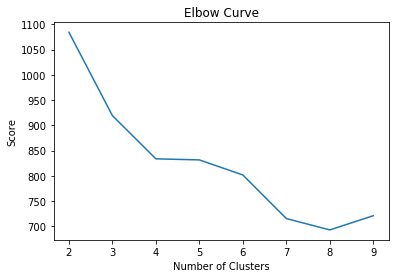

In [40]:
# Calculate cost and plot

cost = np.zeros(10)

for k in range(2,10):
    kmeans_test = KMeans(k=k, seed=3, featuresCol='pcaFeatures', predictionCol='prediction_test')
    model_test = kmeans_test.fit(transformedData)
    cost[k] = model_test.computeCost(transformedData)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)


pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

##### Silhouette method

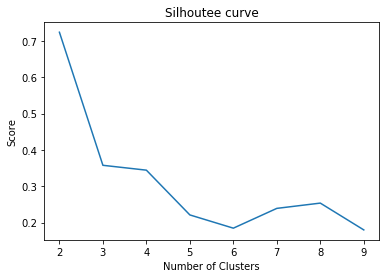

In [44]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans_test = KMeans(k=k, seed=3, featuresCol='pcaFeatures', predictionCol='prediction_test')
    model_test = kmeans_test.fit(transformedData)
    clusteredData = model_test.transform(transformedData)
    evaluator = ClusteringEvaluator(featuresCol='pcaFeatures', predictionCol='prediction_test')
    cost[k] = evaluator.evaluate(clusteredData)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Silhoutee curve')
pl.show()

## Unpersist the persisted DF and end spark session

In [46]:
# papersData.unpersist()
# spark.stop()